# Flow Around a Square and Flow Visualization with Passive Scalar

![image info](Square.svg)

<div class="alert alert-info">

The no-flux boundary condition for the scalar field(s) at the slid/fluid interface is experimental, and it is still not available at XCompact3d's main repository.

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xcompact3d_toolbox as x3d

## Parameters

+ Numerical precision

Use `np.float64` if Xcompact3d was compiled with the flag `-DDOUBLE_PREC`, use `np.float32` otherwise.

In [2]:
x3d.param["mytype"] = np.float64

* Xcompact3d's parameters

For more information about them, checkout the [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.parameters.Parameters).

In [3]:
prm = x3d.Parameters(
    filename="input.i3d",
    # BasicParam
    itype=12,
    p_row=0,
    p_col=0,
    nx=257,
    ny=129,
    nz=32,
    xlx=15.0,
    yly=10.0,
    zlz=3.0,
    nclx1=2,
    nclxn=2,
    ncly1=1,
    nclyn=1,
    nclz1=0,
    nclzn=0,
    iin=1,
    re=300.0,
    init_noise=0.0125,
    inflow_noise=0.0125,
    dt=0.0025,
    ifirst=1,
    ilast=90000,
    ilesmod=1,
    iibm=2, # This is experimental, not available at the main repo
    # NumOptions
    nu0nu=4.0,
    cnu=0.44,
    # InOutParam
    irestart=0,
    icheckpoint=45000,
    ioutput=500,
    iprocessing=100,
    # LESModel
    jles=4,
    # ScalarParam
    numscalar=1,
    nclxS1=2,
    nclxSn=2,
    nclyS1=1,
    nclySn=1,
    nclzS1=0,
    nclzSn=0,
    sc=[1.0],
    ri=[0.0],  # Zero for numerical dye
    uset=[0.0],  # Zero for numerical dye
    cp=[1.0],
    #iibmS=3, # This is experimental, not available at the main repo
)

## Setup

### Geometry

Everything needed is in one dictionary of Arrays (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_epsi)):

In [4]:
epsi = x3d.init_epsi(prm)

The four $\epsilon$ matrices are stored in a dictionary:

In [5]:
epsi.keys()

dict_keys(['epsi', 'xepsi', 'yepsi', 'zepsi'])

Now we draw a square:

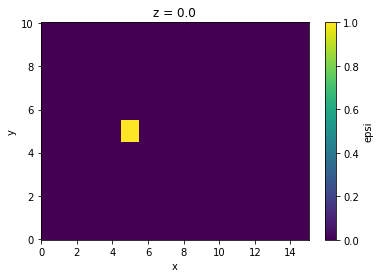

In [6]:
# Here we set the center
center = dict(x=prm.xlx / 3.0, y=prm.yly / 2.0)

# And apply geo.box over the four arrays
for key in epsi.keys():
    epsi[key] = epsi[key].geo.box(
        x=[center["x"] - 0.5, center["x"] + 0.5],
        y=[center["y"] - 0.5, center["y"] + 0.5],
    )

# A quickie plot for reference
epsi["epsi"].sel(z=0, method="nearest").plot(x="x");

<div class="alert alert-info">

Curved surfaces are not supported (yet?) for the no-flux condition for the scalar field(s) at the solid/fluid interface, so let's stay with the square.

</div>

The next step is to produce all the auxiliary files describing the geometry, so then Xcompact3d can read them:

In [7]:
%%time
dataset = x3d.gene_epsi_3D(epsi, prm)

prm.nobjmax = dataset.obj.size

dataset

x
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

y
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

z
       nobjraf : 1
    nobjmaxraf : 1
           bug : 0

number of points with potential problem in x : 0
number of points with potential problem in y : 0
number of points with potential problem in z : 0

Writing...
Wall time: 5.32 s


<xarray.Dataset>
Dimensions:       (obj_aux: 2, obj: 1, x: 257, y: 129, z: 32)
Coordinates:
  * obj_aux       (obj_aux) int32 -1 0
  * obj           (obj) int32 0
  * x             (x) float64 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 0.0 0.09375 0.1875 0.2812 ... 2.719 2.812 2.906
Data variables: (12/28)
    epsi          (x, y, z) bool False False False False ... False False False
    nobj_x        (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmax_x     int64 1
    nobjraf_x     (y, z) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nobjmaxraf_x  int64 1
    ibug_x        int64 0
    ...            ...
    nxipif_y      (x, z, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_y      (x, z, obj_aux) int64 128 2 128 2 128 2 ... 128 2 128 2 128 2
    xi_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    xf_z          (x, y, obj) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nxipif_z      (x, y, obj_aux) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    nxfpif_z      (x, y, obj_aux) int64 31 2 31 2 31 2 31 2 ... 2 31 2 31 2 31 2

### Boundary Condition

Everything needed is in one Dataset (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_dataset)):

In [8]:
ds = x3d.init_dataset(prm)

Let's see it, data and attributes are attached, try to interact with the icons:

In [9]:
ds

<xarray.Dataset>
Dimensions:       (x: 257, y: 129, z: 32, n: 1)
Coordinates:
  * x             (x) float64 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 0.0 0.09375 0.1875 0.2812 ... 2.719 2.812 2.906
  * n             (n) int32 1
Data variables:
    bxx1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bxy1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bxz1          (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    noise_mod_x1  (y, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bxphi1        (n, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ux            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uy            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uz            (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    phi           (n, x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

**Inflow profile**: Since the boundary conditions for velocity at the top and at the bottom are free-slip in this case (`ncly1=nclyn=1`), the inflow profile for streamwise velocity is just 1 everywhere:

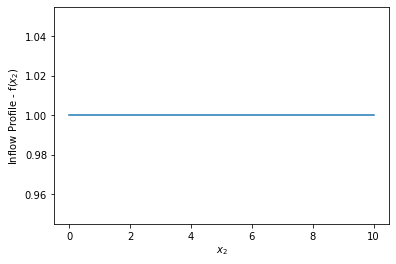

In [10]:
fun = xr.ones_like(ds.y)

# This attribute will be shown in the figure
fun.attrs["long_name"] = r"Inflow Profile - f($x_2$)"

fun.plot();

Now, we reset the inflow planes `ds[key] *= 0.0`, just to guarantee consistency in case of multiple executions of this cell. Notice that `ds[key] = 0.0` may overwrite all the metadata contained in the array, so it should be avoided. Then, we add the inflow profile to the streamwise componente and plot them for reference:

Inflow Plane for Streamwise Velocity


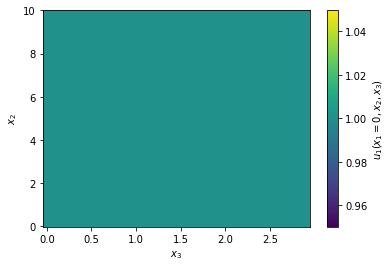

Inflow Plane for Vertical Velocity


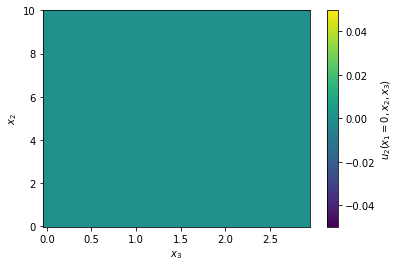

Inflow Plane for Spanwise Velocity


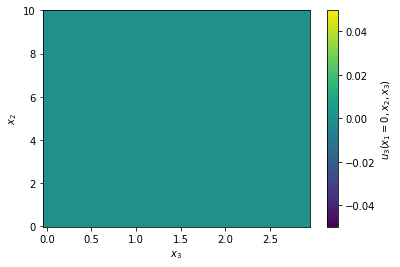

In [11]:
for key in "bxx1 bxy1 bxz1".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    #
    if key == "bxx1":
        ds[key] += fun
    #
    ds[key].plot()
    plt.show()

plt.close("all")

A random noise will be applied at the inflow boundary, we can create a modulation function `mod` to control were it will be applied. In this case, we will concentrate the noise near the center region and make it zero were $y=0$ and $y=L_y$. The domain is periodic in $z$ `nclz1=nclzn=0`, so there is no need to make `mod` functions of $z$. The functions looks like:

$$
\text{mod} = \exp\left(-0.2 (y - 0.5 L_y)^2 \right).
$$

See the code:

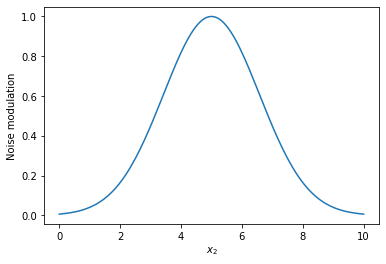

In [12]:
# Random noise with fixed seed,
# important for reproducibility, development and debugging
if prm.iin == 2:
    np.random.seed(seed=67)

mod = np.exp(-0.2 * (ds.y - ds.y[-1] * 0.5) ** 2.0)

# This attribute will be shown in the figure
mod.attrs["long_name"] = "Noise modulation"

mod.plot();

Again, we reset the array `ds['noise_mod_x1'] *= 0.0`, just to guarantee consistency in case of multiple executions of this cell. Notice that `ds['noise_mod_x1'] *= 0.0` may overwrite all the metadata contained in the array, so it should be avoided. Then, we add the modulation profile to the proper array and plot it for reference:

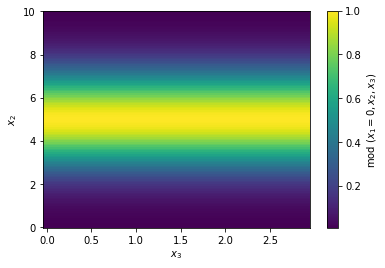

In [13]:
ds["noise_mod_x1"] *= 0.0
ds["noise_mod_x1"] += mod

ds.noise_mod_x1.plot();

Notice one of the many advantages of using [xarray](http://xarray.pydata.org/en/stable/), `mod`, with shape (`ny`), was automatically broadcasted for every point in `z` into `ds.noise_mod_x1`, with shape (`ny`, `nz`).

**Inflow BC for the passive scalar**: For this case, the choise was a "smooth" square wave, because it is differentiable.

Notice that Xcompact3d supports multiple scalar fields (controlled by `numscalar`, this example just includes one), so different visualization patterns can be set for each one of them.


Inflow Plane for Scalar field(s)


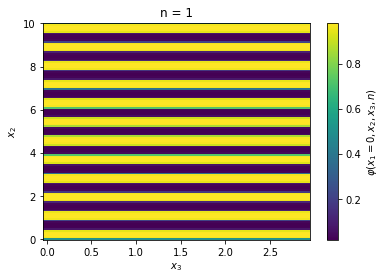

In [14]:
# Concentration

print(ds["bxphi1"].attrs["name"])

ds["bxphi1"] *= 0.0

for n in range(prm.numscalar):

    ds["bxphi1"][dict(n=n)] += (
        0.5
        + np.arctan(
            np.sin(2.0 * np.pi * ds.y / prm.yly * 11.5) * (prm.sc[n] * prm.re) ** 0.5
        )
        / np.pi
    )

    ds.bxphi1.isel(n=n).plot()
    plt.show()

plt.close("all")

### Initial Condition

Now we reset velocity fields `ds[key] *= 0.0`, just to guarantee consistency in the case of multiple executions of this cell.

We then add a random number array with the right shape, multiply by the noise amplitude at the initial condition `init_noise` and multiply again by our modulation function `mod`, defined previously. Finally, we add the streamwise profile `fun` to `ux` and make the plots for reference, I'm adding extra options just to exemplify how easily we can slice the spanwise coordinate and produce multiple plots:

Initial Condition for Streamwise Velocity


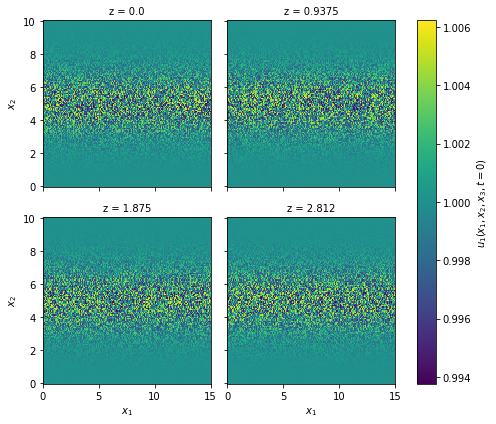

Initial Condition for Vertical Velocity


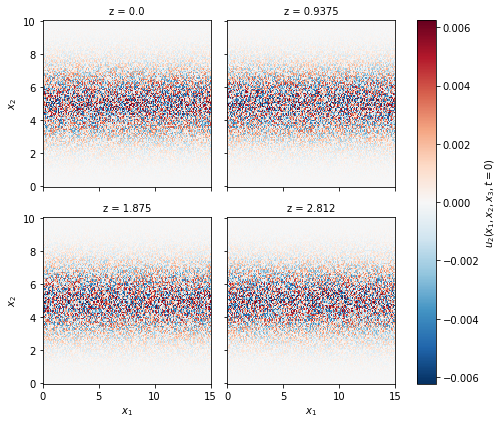

Initial Condition for Spanwise Velocity


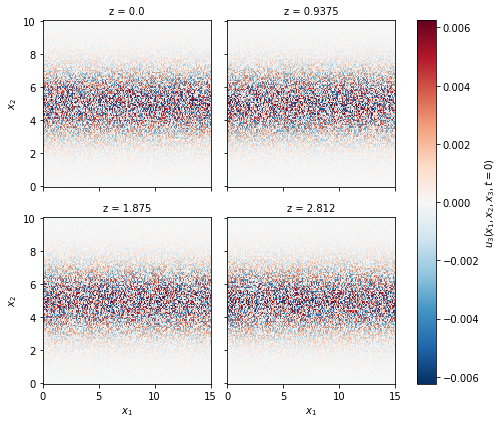

In [15]:
for key in "ux uy uz".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    ds[key] += prm.init_noise * ((np.random.random(ds[key].shape) - 0.5))
    ds[key] *= mod
    #
    if key == "ux":
        ds[key] += fun
    #
    ds[key].sel(z=slice(None, None, ds.z.size // 3)).plot(
        x="x", y="y", col="z", col_wrap=2
    )
    plt.show()
    #

plt.close("all")

For concentration, let's start with a clean domain:

In [16]:
ds["phi"] *= 0

## Writing to the disc

is as simple as:

In [17]:
prm.dataset.write(ds)

In [18]:
prm.write()

## Running the Simulation

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, keep in mind the aspects of numerical stability of our Navier-Stokes solver. **It is up to the user to find the right set of numerical and physical parameters**.

Make sure that the compiling flags and options at `Makefile` are what you expect. Then, compile the main code at the root folder with `make`.

And finally, we are good to go:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```